This tutorial example is on the application of CNN image segmentation on salt identification. The train and test data were gotten from TGS-Kaggle Salt Identification challenge in 2018: https://www.kaggle.com/c/tgs-salt-identification-challenge/ . A majority of the code in this notebook was extracted from: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277 by Kjetil Åmdal-Sævik.

The train data consist of 4000 (101 by 101) seismic patches and 4000 corresponding masks indicating regions of salt presence or not. The test data consist of 18000 (101 by 101) seismic patches. The aim of the competition was to predict regions of salt or no salt on the test seismic patches.

In this example, we will be covering how to use th U-Net model (a popular type of image segmentation model) to identify salt regions from seismic image patches and the following;

* Loading the data and preparation
* Training the U-Net
* Saving the trained model
* Prediction
* Visualizations

In [1]:
# import required libraries and packages

import os, sys, random, warnings
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

import tensorflow as tf

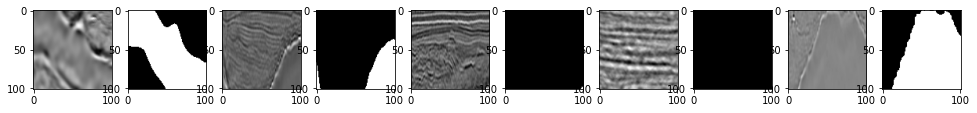

In [2]:
# Display some example image and mask patches

ids= ['0a1742c740','5b7c160d0d','6c40978ddf','7dfdf6eeb8','1ee0d5b4d0']

plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('./train/images/' + img_name + '.png')
    img_mask = load_img('./train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()


#Dark patches indicate no salts in the image

### Loading the data and preparation

Getting training image ids to load image and mask data

In [3]:
path_train = './train/'   # path to train images and masks
path_test = './test/'     # path to test images

train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [4]:
len(train_ids), len(test_ids)

(4000, 18000)

In [5]:
train_ids[:5]

['000e218f21.png',
 '003c477d7c.png',
 '00441f1cf2.png',
 '0050766ae2.png',
 '005b452274.png']

Image and mask patches will be resized to 128px by 128px from original 101px by 101px

In [6]:
im_height = 128    # new height
im_width = 128    # new width
im_chan = 1     # number of image channel

Creating empty arrays to hold resized train and test image data

In [7]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.bool)

In [8]:
X_train.shape, Y_train.shape

((4000, 128, 128, 1), (4000, 128, 128, 1))

In [9]:
X_train[0]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [10]:
Y_train[1]

array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

Resizing train images and masks

In [11]:
path = path_train
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

<ipython-input-11-a84688fe9ea7>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):



Done!


In [12]:
X_train.shape

(4000, 128, 128, 1)

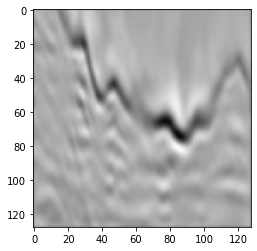

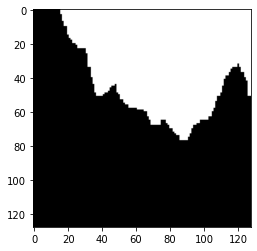

In [13]:
# Quakity check to see if training data looks all right

ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

Loading and resizing test image patches

In [14]:
# creating empty test image arrays

X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)

In [15]:
X_test.shape

(18000, 128, 128, 1)

In [16]:
path = path_test
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

<ipython-input-16-bb067d74bd43>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):



Done!


In [17]:
X_train.shape, X_test.shape, Y_train.shape

((4000, 128, 128, 1), (18000, 128, 128, 1), (4000, 128, 128, 1))

### Model Training with the U-Net Architecture

![U-Net architecture.png](images/u-net-architecture.png)

In [18]:
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
c1

<KerasTensor: shape=(None, 128, 128, 8) dtype=float32 (created by layer 'conv2d_1')>

In [19]:
s

<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'lambda')>

In [20]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)


# CONTRASTIVE and ENCODING PART
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

# EXPANSIVE and DECODING PART
u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

# OUTPUT LAYER
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 8)  584         conv2d_2[0][0]                   
______________________________________________________________________________________________

### Saving the trained model

Specify model hyperparameters, and call backs to save the model

In [22]:
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('TGS-salt-model-1.h5', verbose=1, save_best_only=True)

In [23]:
epochs = 15
batch_size = 8
validation_size = 0.2

Train the model

In [24]:
results = model.fit(X_train, Y_train, validation_split=validation_size, 
                    batch_size=batch_size, epochs=epochs, callbacks=[earlystopper, checkpointer])

Epoch 1/15
400/400 [==============================] - 199s 488ms/step - loss: 0.5836 - accuracy: 0.7408 - val_loss: 0.5430 - val_accuracy: 0.7603

Epoch 00001: val_loss improved from inf to 0.54298, saving model to TGS-salt-model-1.h5
Epoch 2/15
400/400 [==============================] - 197s 493ms/step - loss: 0.5453 - accuracy: 0.7527 - val_loss: 0.4149 - val_accuracy: 0.8283

Epoch 00002: val_loss improved from 0.54298 to 0.41491, saving model to TGS-salt-model-1.h5
Epoch 3/15
400/400 [==============================] - 205s 512ms/step - loss: 0.4168 - accuracy: 0.8300 - val_loss: 0.3657 - val_accuracy: 0.8546

Epoch 00003: val_loss improved from 0.41491 to 0.36573, saving model to TGS-salt-model-1.h5
Epoch 4/15
400/400 [==============================] - 201s 503ms/step - loss: 0.3721 - accuracy: 0.8530 - val_loss: 0.2907 - val_accuracy: 0.8876

Epoch 00004: val_loss improved from 0.36573 to 0.29066, saving model to TGS-salt-model-1.h5
Epoch 5/15
400/400 [============================

### Prediction

Making use of the best saved model to make train, test prediction

In [25]:
# Predict on train, val and test
model = load_model('TGS-salt-model-1.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.8):], verbose=1)

preds_test = model.predict(X_test, verbose=1)    # test data

563/563 [==============================] - 220s 389ms/step


In [26]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [28]:
preds_train_t.shape, preds_val_t.shape, preds_test_t.shape

((3200, 128, 128, 1), (800, 128, 128, 1), (18000, 128, 128, 1))

### Visualizations

Visualizing the predicted samples (train and test)

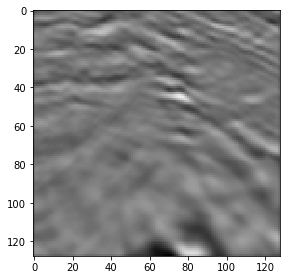

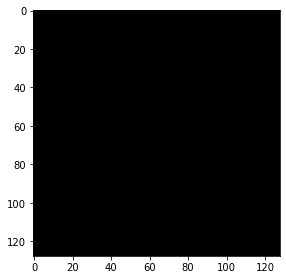

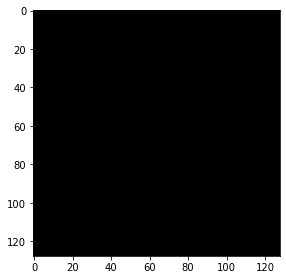

In [83]:
# Train samples predicted

ix = random.randint(0, len(preds_train_t))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

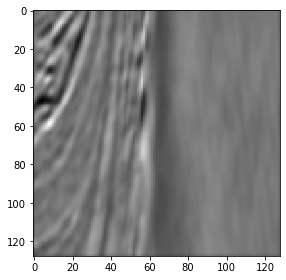

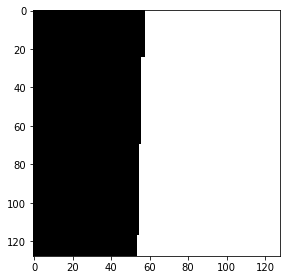

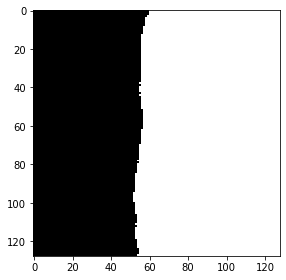

In [82]:
# Train samples predicted

ix = random.randint(0, len(preds_train_t))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

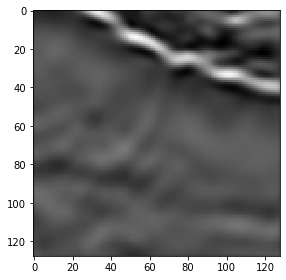

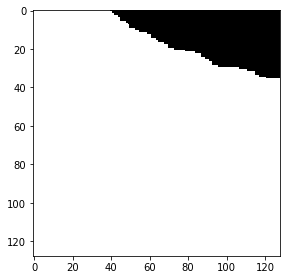

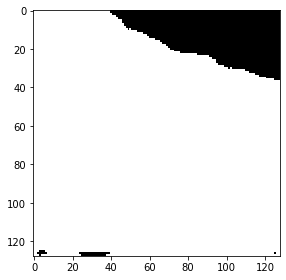

In [87]:
# Train samples predicted

ix = random.randint(0, len(preds_train_t))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

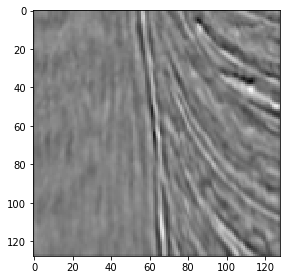

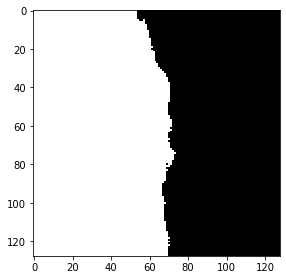

In [68]:
# Test samples predicted

ix = random.randint(0, len(preds_test_t))
imshow(np.squeeze(X_test[ix]))
plt.show()
tmp = np.squeeze(preds_test_t[ix]).astype(np.float32)
imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

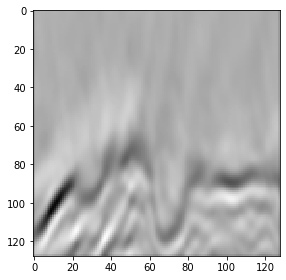

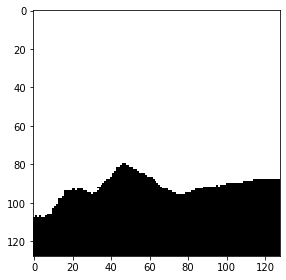

In [70]:
# Test samples predicted

ix = random.randint(0, len(preds_test_t))
imshow(np.squeeze(X_test[ix]))
plt.show()
tmp = np.squeeze(preds_test_t[ix]).astype(np.float32)
imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

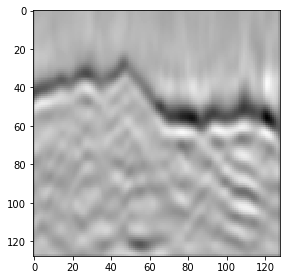

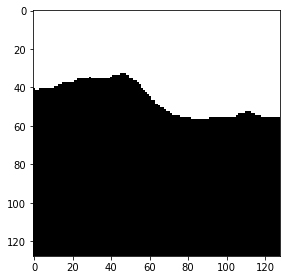

In [81]:
# Test samples predicted

ix = random.randint(0, len(preds_test_t))
imshow(np.squeeze(X_test[ix]))
plt.show()
tmp = np.squeeze(preds_test_t[ix]).astype(np.float32)
imshow(np.dstack((tmp,tmp,tmp)))
plt.show()